# **Redes Neurais**
## **Modelo 4 - Redes Neurais Recorrentes (RNN)**

- Tales Miguel
- RA: 140247

- Professor Dr. Marcos G. Quiles

## **Instruções**
### **PROJETO 4 - RNN**


- Implementar um modelo LSTM ou GRU para uma das tarefas abaixo:
  1. Classificação de série temporais. O modelo deve receber uma janela temporal (qualquer tipo de dado) e classificar o conteúdo da janela.
   
  2. Previsão. Treinar um modelo para predizer o valor de uma variável no instante t+k. O modelo deve receber os dados da série temporal (instantes anteriores a t – verificar tamanho da janela) e predizer um valor futuro. k a distância da predição. Por exemplo, podemos alimentar um modelo com dados de uma dada empresa (i.e. PETR3) e tentar predizer qual será o valor da ação daqui 5 dias (k==5)
  
  3. Autoencoder recorrente. O modelo deve mapear a série temporal na própria série. O objetivo será avaliar como os dados estão representados no espaço latente

## **Tarefa 2 - Predição de Valores de Ações com LSTM**

Implementação de um modelo LSTM para predizer valores futuros de ações da NVIDIA (NVDA). O modelo recebe uma janela temporal de T=60 dias e prediz o valor de fechamento para T+5 (5 dias à frente).

### **1. Imports e Configuração**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import yfinance as yf
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

2025-11-12 17:14:11.723126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 17:14:11.728896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762978451.736224  187540 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762978451.738688  187540 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762978451.744196  187540 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### **2. Coleta dos Dados da NVIDIA**

Coleta dos dados históricos de ações da NVIDIA (NVDA) dos últimos 5 anos utilizando a biblioteca yfinance. Utilizarei apenas o valor de fechamento ('Close') para a predição.

/tmp/ipykernel_187540/2476785459.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda_data = yf.download('NVDA', start=start_date, end=end_date, progress=False)


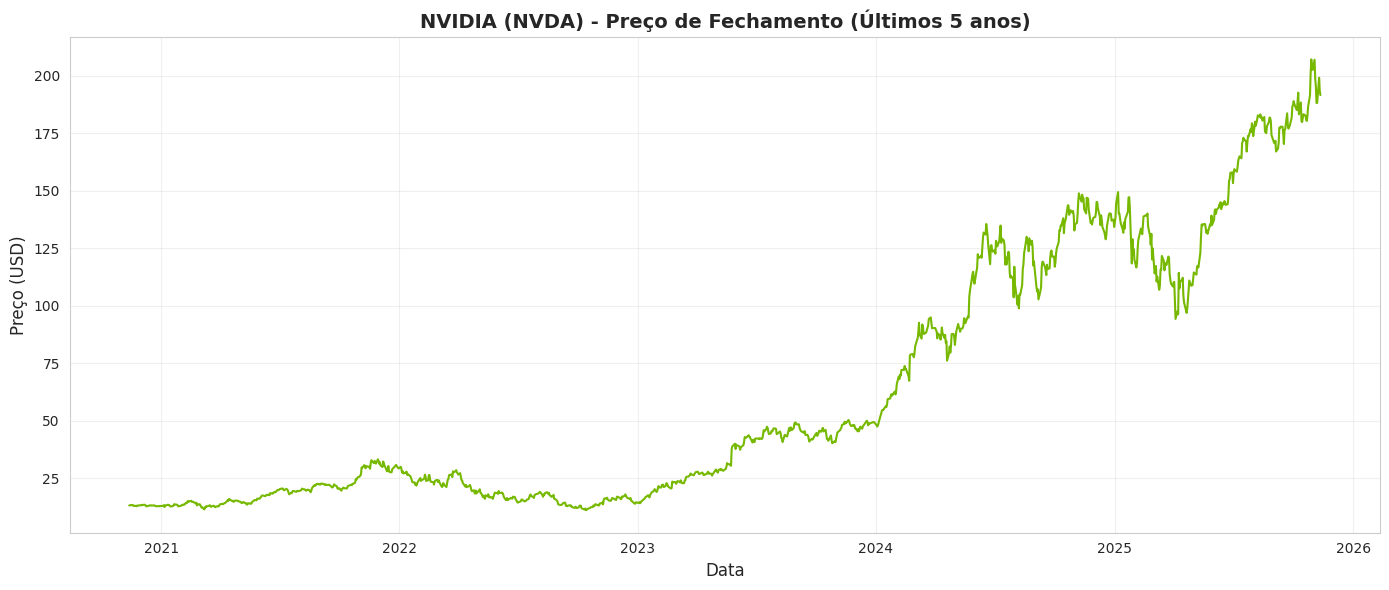

Período: 2020-11-13 até 2025-11-12
Total de dias: 1255
Preço mínimo: $11.21
Preço máximo: $207.04
Preço médio: $62.75


In [2]:
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

nvda_data = yf.download('NVDA', start=start_date, end=end_date, progress=False)

df = pd.DataFrame({
    'Date': nvda_data.index,
    'Close': nvda_data['Close'].values.flatten()
})
df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df['Date'], df['Close'], linewidth=1.5, color='#76b900')
ax.set_title('NVIDIA (NVDA) - Preço de Fechamento (Últimos 5 anos)', fontsize=14, fontweight='bold')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Preço (USD)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Período: {df['Date'].iloc[0].strftime('%Y-%m-%d')} até {df['Date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"Total de dias: {len(df)}")
print(f"Preço mínimo: ${df['Close'].min():.2f}")
print(f"Preço máximo: ${df['Close'].max():.2f}")
print(f"Preço médio: ${df['Close'].mean():.2f}")

### **3. Preparação dos Dados**

Criação das janelas temporais para o modelo LSTM. Cada janela contém T=60 dias consecutivos para predizer o valor 5 dias à frente (T+5).

In [3]:
T = 60  # look back (time window in days)
k = 5   # forward days

scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

def create_sequences(data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+prediction_horizon-1])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_scaled, T, k)

train_size = int(0.8 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"Janela temporal (T): {T} dias")
print(f"Horizonte de predição (k): {k} dias")
print(f"Total de sequências: {len(X)}")
print(f"Treino: {len(X_train)} sequências")
print(f"Teste: {len(X_test)} sequências")
print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")

Janela temporal (T): 60 dias
Horizonte de predição (k): 5 dias
Total de sequências: 1191
Treino: 952 sequências
Teste: 239 sequências
Shape X_train: (952, 60, 1)
Shape y_train: (952, 1)


### **4. Construção do Modelo LSTM**

Arquitetura do modelo com camadas LSTM para capturar dependências temporais nos dados de preços.

In [4]:


model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(T, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

I0000 00:00:1762978454.248505  187540 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5519 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/tales/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

### **5. Treinamento**

Treinamento de dois modelos: um com early stopping (patience=20) e outro sem early stopping, para comparar o impacto dessa técnica na performance e overfitting.

In [5]:
model_1 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(T, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_2 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(T, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_with_early_stop = model_1.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

history_without_early_stop = model_2.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100


I0000 00:00:1762978455.611122  187724 cuda_dnn.cc:529] Loaded cuDNN version 91301


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0029 - mae: 0.0372 - val_loss: 0.0042 - val_mae: 0.0519
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0029 - mae: 0.0372 - val_loss: 0.0042 - val_mae: 0.0519
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0499e-04 - mae: 0.0164 - val_loss: 0.0165 - val_mae: 0.1083
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0499e-04 - mae: 0.0164 - val_loss: 0.0165 - val_mae: 0.1083
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2456e-04 - mae: 0.0132 - val_loss: 0.0110 - val_mae: 0.0853
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2456e-04 - mae: 0.0132 - val_loss: 0.0110 - val_mae: 0.0853
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8587e-04 - mae: 0.0125 - val_loss: 0.0100 - val_mae: 0.0807
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8587e-04 - mae: 0.0125 - val_loss: 0.0100 - val_mae: 0.0807
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

### **6. Visualização do Treinamento**

Comparação entre o modelo com early stopping e sem early stopping, analisando a evolução das métricas de perda e erro absoluto médio.

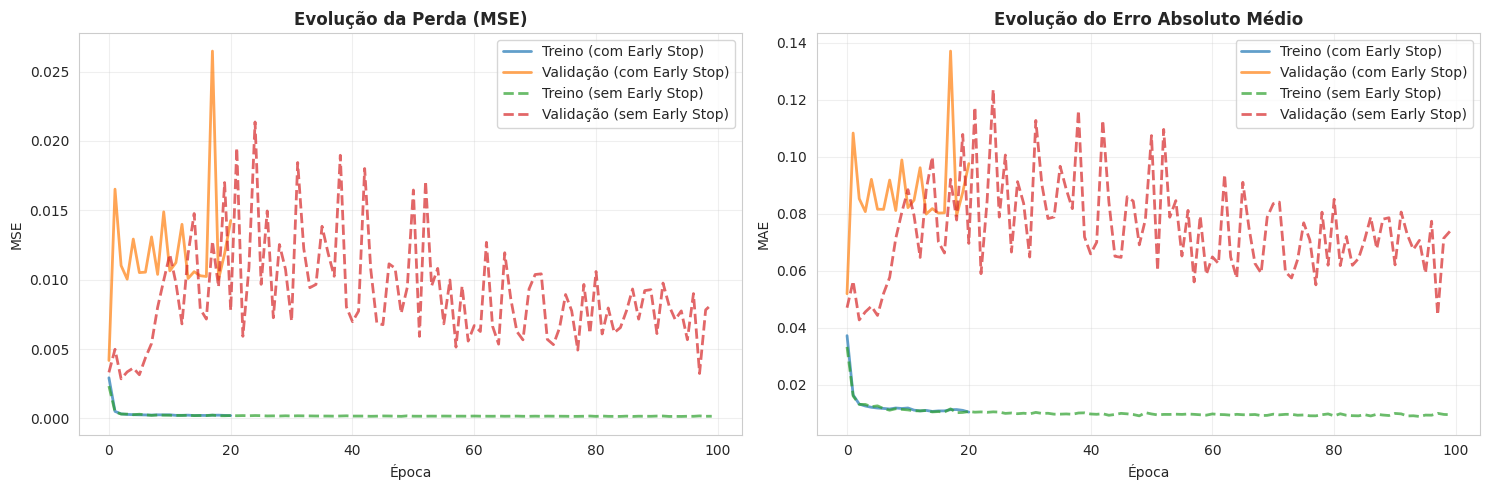

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_with_early_stop.history['loss'], label='Treino (com Early Stop)', linewidth=2, alpha=0.7)
axes[0].plot(history_with_early_stop.history['val_loss'], label='Validação (com Early Stop)', linewidth=2, alpha=0.7)
axes[0].plot(history_without_early_stop.history['loss'], label='Treino (sem Early Stop)', linewidth=2, alpha=0.7, linestyle='--')
axes[0].plot(history_without_early_stop.history['val_loss'], label='Validação (sem Early Stop)', linewidth=2, alpha=0.7, linestyle='--')
axes[0].set_title('Evolução da Perda (MSE)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_with_early_stop.history['mae'], label='Treino (com Early Stop)', linewidth=2, alpha=0.7)
axes[1].plot(history_with_early_stop.history['val_mae'], label='Validação (com Early Stop)', linewidth=2, alpha=0.7)
axes[1].plot(history_without_early_stop.history['mae'], label='Treino (sem Early Stop)', linewidth=2, alpha=0.7, linestyle='--')
axes[1].plot(history_without_early_stop.history['val_mae'], label='Validação (sem Early Stop)', linewidth=2, alpha=0.7, linestyle='--')
axes[1].set_title('Evolução do Erro Absoluto Médio', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **7. Predições no Conjunto de Teste**

Avaliação e comparação de métricas dos dois modelos (com e sem early stopping) no conjunto de teste.

In [ ]:
y_pred_with_early_scaled = model_1.predict(X_test, verbose=0)
y_pred_without_early_scaled = model_2.predict(X_test, verbose=0)

y_pred_with_early = scaler.inverse_transform(y_pred_with_early_scaled)
y_pred_without_early = scaler.inverse_transform(y_pred_without_early_scaled)
y_test_original = scaler.inverse_transform(y_test)

mse_with = mean_squared_error(y_test_original, y_pred_with_early)
rmse_with = np.sqrt(mse_with)
mae_with = mean_absolute_error(y_test_original, y_pred_with_early)
r2_with = r2_score(y_test_original, y_pred_with_early)
mape_with = np.mean(np.abs((y_test_original - y_pred_with_early) / y_test_original)) * 100

mse_without = mean_squared_error(y_test_original, y_pred_without_early)
rmse_without = np.sqrt(mse_without)
mae_without = mean_absolute_error(y_test_original, y_pred_without_early)
r2_without = r2_score(y_test_original, y_pred_without_early)
mape_without = np.mean(np.abs((y_test_original - y_pred_without_early) / y_test_original)) * 100

print(f"{'='*60}")
print(f"Métricas de Avaliação - Modelo COM Early Stop")
print(f"{'='*60}")
print(f"MSE:   {mse_with:.2f}")
print(f"RMSE:  {rmse_with:.2f}")
print(f"MAE:   {mae_with:.2f}")
print(f"R²:    {r2_with:.4f}")
print(f"MAPE:  {mape_with:.2f}%")
print()
print(f"{'='*60}")
print(f"Métricas de Avaliação - Modelo SEM Early Stop")
print(f"{'='*60}")
print(f"MSE:   {mse_without:.2f}")
print(f"RMSE:  {rmse_without:.2f}")
print(f"MAE:   {mae_without:.2f}")
print(f"R²:    {r2_without:.4f}")
print(f"MAPE:  {mape_without:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Métricas de Avaliação (Conjunto de Teste - Modelo com Early Stop):
MSE: 258.49
RMSE: 16.08
MAE: 13.26
R²: 0.6786
MAPE: 9.59%
Métricas de Avaliação (Conjunto de Teste - Modelo com Early Stop):
MSE: 258.49
RMSE: 16.08
MAE: 13.26
R²: 0.6786
MAPE: 9.59%


### **8. Visualização das Predições**

Comparação visual entre valores preditos dos dois modelos e valores reais no conjunto de teste.

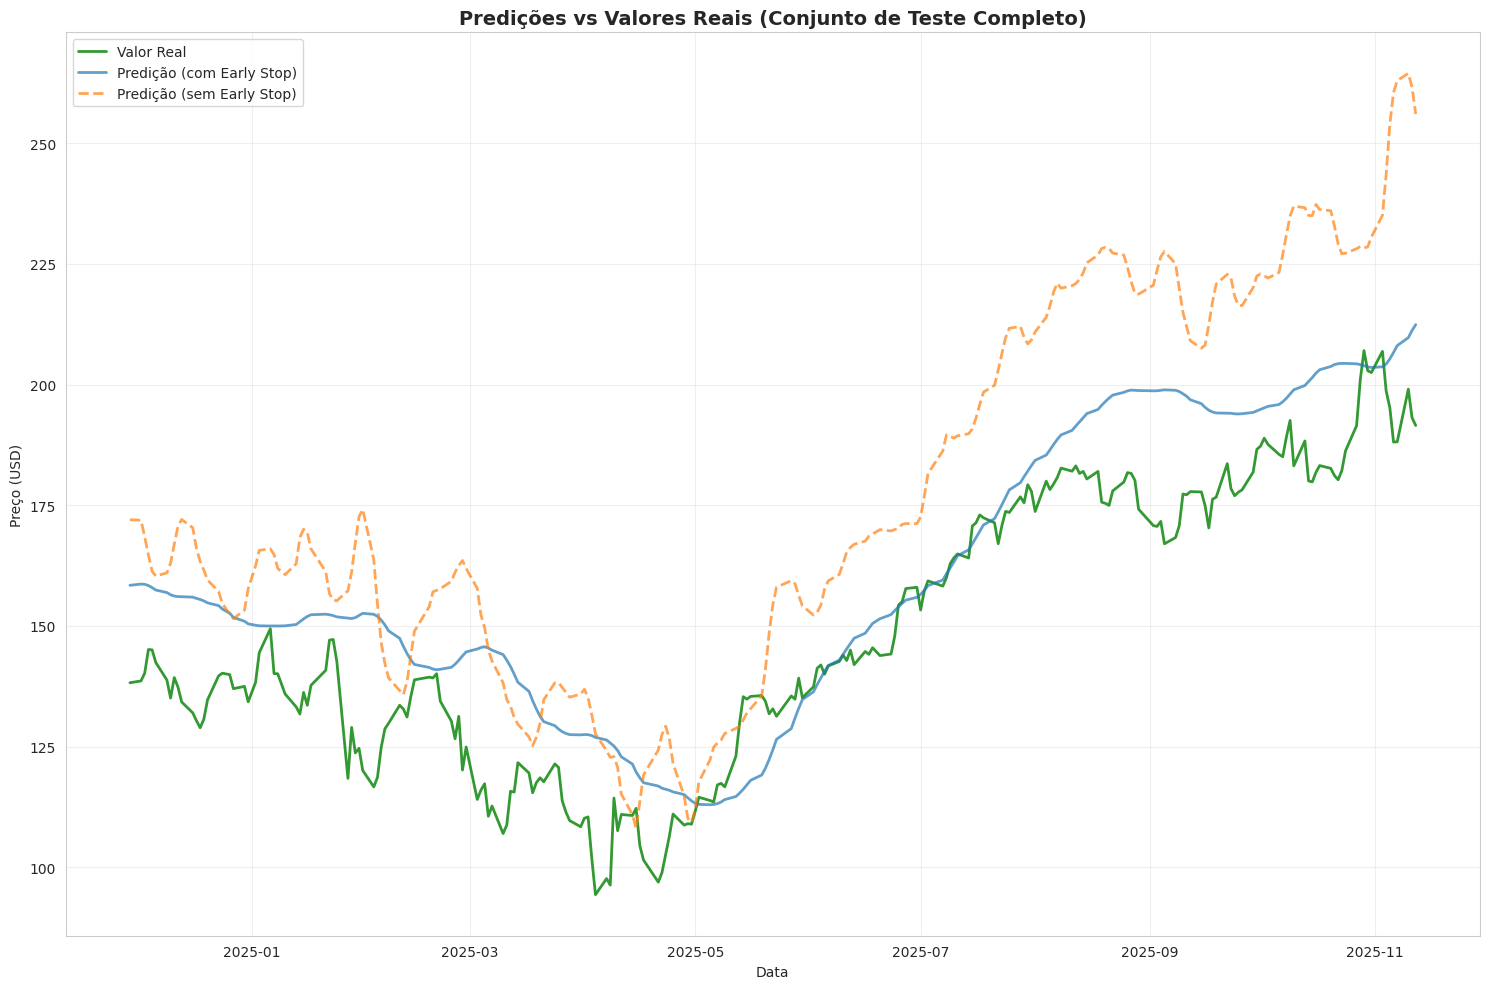

In [13]:
y_pred_with_early_scaled = model_1.predict(X_test, verbose=0)
y_pred_without_early_scaled = model_2.predict(X_test, verbose=0)

y_pred_with_early = scaler.inverse_transform(y_pred_with_early_scaled)
y_pred_without_early = scaler.inverse_transform(y_pred_without_early_scaled)

test_dates = df['Date'].iloc[train_size + T + k - 1:train_size + T + k - 1 + len(y_test)].values

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.plot(test_dates, y_test_original, label='Valor Real', linewidth=2, alpha=0.8, color='green')
ax.plot(test_dates, y_pred_with_early, label='Predição (com Early Stop)', linewidth=2, alpha=0.7)
ax.plot(test_dates, y_pred_without_early, label='Predição (sem Early Stop)', linewidth=2, alpha=0.7, linestyle='--')
ax.set_title('Predições vs Valores Reais (Conjunto de Teste Completo)', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Preço (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

sample_size = min(100, len(test_dates))
plt.tight_layout()
plt.show()

### **9. Análise de Erros**

Comparação da distribuição dos erros de predição entre os dois modelos para identificar diferenças de performance.

In [ ]:
errors_with_early = y_test_original - y_pred_with_early
errors_without_early = y_test_original - y_pred_without_early
percentage_errors_with_early = (errors_with_early / y_test_original) * 100
percentage_errors_without_early = (errors_without_early / y_test_original) * 100

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(errors_with_early, bins=50, edgecolor='black', alpha=0.7, label='Com Early Stop')
axes[0, 0].hist(errors_without_early, bins=50, edgecolor='black', alpha=0.5, label='Sem Early Stop')
axes[0, 0].set_title('Distribuição dos Erros (USD)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Erro de Predição (USD)')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(percentage_errors_with_early, bins=50, edgecolor='black', alpha=0.7, label='Com Early Stop')
axes[0, 1].hist(percentage_errors_without_early, bins=50, edgecolor='black', alpha=0.5, label='Sem Early Stop')
axes[0, 1].set_title('Distribuição dos Erros Percentuais', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Erro Percentual (%)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(y_test_original, y_pred_with_early, alpha=0.5, s=20, label='Com Early Stop')
axes[1, 0].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 
                'r--', linewidth=2, label='Predição Perfeita')
axes[1, 0].set_title('Real vs Predição (Com Early Stop)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Valor Real (USD)')
axes[1, 0].set_ylabel('Predição (USD)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test_original, y_pred_without_early, alpha=0.5, s=20, color='orange', label='Sem Early Stop')
axes[1, 1].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 
                'r--', linewidth=2, label='Predição Perfeita')
axes[1, 1].set_title('Real vs Predição (Sem Early Stop)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Valor Real (USD)')
axes[1, 1].set_ylabel('Predição (USD)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Estatísticas dos Erros (Com Early Stop):")
print(f"Média: ${errors_with_early.mean():.2f}")
print(f"Mediana: ${np.median(errors_with_early):.2f}")
print(f"Desvio Padrão: ${errors_with_early.std():.2f}")
print(f"Min: ${errors_with_early.min():.2f}")
print(f"Max: ${errors_with_early.max():.2f}")
print()
print(f"Estatísticas dos Erros (Sem Early Stop):")
print(f"Média: ${errors_without_early.mean():.2f}")
print(f"Mediana: ${np.median(errors_without_early):.2f}")
print(f"Desvio Padrão: ${errors_without_early.std():.2f}")
print(f"Min: ${errors_without_early.min():.2f}")
print(f"Max: ${errors_without_early.max():.2f}")

### **10. Conclusões**

Usar apenas uma LSTM não é suficiente para prever o comportamento de uma ação no mercado. Quando usamos apenas o histórico de preço de closing de ações de uma empresa, a previsão fica longe da realidade. O mercado financeiro é muito volátil e não depende apenas de padrões históricos para seu desdobramento.